# Evaluate your LLM application

## Create a dataset

In [1]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

In [2]:
from langsmith import Client

client = Client()

# Define dataset: these are your test cases
dataset_name = "QA Example Dataset"


In [ ]:
dataset = client.create_dataset(dataset_name)
client.create_examples(
    inputs = [
        {"question": "What is LangChain?"},
        {"question": "What is LangSmith?"},
        {"question": "What is OpenAI?"},
        {"question": "What is Google?"},
        {"question": "What is Mistral?"},
    ],
    outputs =[
        {"answer": "A framework for building LLM applications"},
        {"answer": "A platform for observing and evaluating LLM applications"},
        {"answer": "A company that creates Large Language Models"},
        {"answer": "A technology company known for search"},
        {"answer": "A company that creates Large Language Models"},
    ],
    dataset_id=dataset.id,

)

## Define metrics
LLM-as-a-judge: An LLM to judge whether the output is correct

In [3]:
os.environ["GROQ_API_KEY"] = getpass.getpass()

In [4]:
from langchain_groq import ChatGroq
from langchain_core.prompts.prompt import PromptTemplate
from langsmith.evaluation import LangChainStringEvaluator

_PROMPT_TEMPLATE = """You are an expert professor specialized in grading students' answers to questions.
You are grading the following question:
{query}
Here is the real answer:
{answer}
You are grading the following predicted answer:
{result}
Respond with CORRECT or INCORRECT:
Grade:
"""

PROMPT = PromptTemplate(
    input_variables=["query", "answer", "result"], template=_PROMPT_TEMPLATE
)
eval_llm = ChatGroq(model="llama3-8b-8192", temperature=0.0)

qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm, "prompt": PROMPT})

In [5]:
from langsmith.schemas import Run, Example

def evaluate_length(run: Run, example: Example) -> dict:
    prediction= run.outputs.get("output") or ""
    required = example.outputs.get("answer") or ""
    score = int(len(prediction) < 2 * len(required))
    return {"key":"length", "score": score}

## Run Evaluations

In [25]:
import ollama

def my_app(question):
    response = ollama.generate(
        model="openhermes",
        prompt=(
            "Respond to the user's question in a short, concise manner (one short sentence).\n"
            f"User: {question}\n"
            "Response:"
        ),
    )
    return response["response"]

# Example usage
answer = my_app("What is the capital of France?")
print(answer)

Paris.


In [15]:
def langsmith_app(inputs):
    output = my_app(inputs["question"])
    return {"output": output}

In [26]:
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    langsmith_app,
    data=dataset_name,
    evaluators=[evaluate_length, qa_evaluator],
    experiment_prefix="openhermes",
)

View the evaluation results for experiment: 'openhermes-50ec6278' at:
https://smith.langchain.com/o/61d90813-dbd8-5ea4-8a7a-14aa80a5a455/datasets/63302751-941e-4adf-bb2c-d1034319ea90/compare?selectedSessions=e0ffcd3a-053d-4887-b686-8d13f5c92526




0it [00:00, ?it/s]

In [6]:
import ollama

def my_app_1(question):
    response = ollama.generate(
        model="llama3",
        prompt=(
            "Respond to the user's question in a short, concise manner (one short sentence).\n"
            f"User: {question}\n"
            "Response:"
        ),
    )
    return response["response"]

def langsmith_app_1(inputs):
    output = my_app_1(inputs["question"])
    return {"output": output}

from langsmith.evaluation import evaluate

experiment_results = evaluate(
    langsmith_app_1,
    data=dataset_name,
    evaluators=[evaluate_length, qa_evaluator],
    experiment_prefix="meta-3",
)

View the evaluation results for experiment: 'meta-3-039873ac' at:
https://smith.langchain.com/o/61d90813-dbd8-5ea4-8a7a-14aa80a5a455/datasets/63302751-941e-4adf-bb2c-d1034319ea90/compare?selectedSessions=002ab489-bebf-44de-907f-cc3f6d88696f




0it [00:00, ?it/s]

In [7]:
import ollama

def my_app_2(question):
    response = ollama.generate(
        model="llama3",
        prompt=(
            "Respond to the user's question in a short, concise manner (one short sentence). Do NOT use more than ten words.\n"
            f"User: {question}\n"
            "Response:"
        ),
    )
    return response["response"]

def langsmith_app_2(inputs):
    output = my_app_2(inputs["question"])
    return {"output": output}

from langsmith.evaluation import evaluate

experiment_results = evaluate(
    langsmith_app_2,
    data=dataset_name,
    evaluators=[evaluate_length, qa_evaluator],
    experiment_prefix="strict-meta-3",
)

View the evaluation results for experiment: 'strict-meta-3-6c53352b' at:
https://smith.langchain.com/o/61d90813-dbd8-5ea4-8a7a-14aa80a5a455/datasets/63302751-941e-4adf-bb2c-d1034319ea90/compare?selectedSessions=bd064ea7-13f6-4e84-981d-9b737979d33f




0it [00:00, ?it/s]

## Comparing result

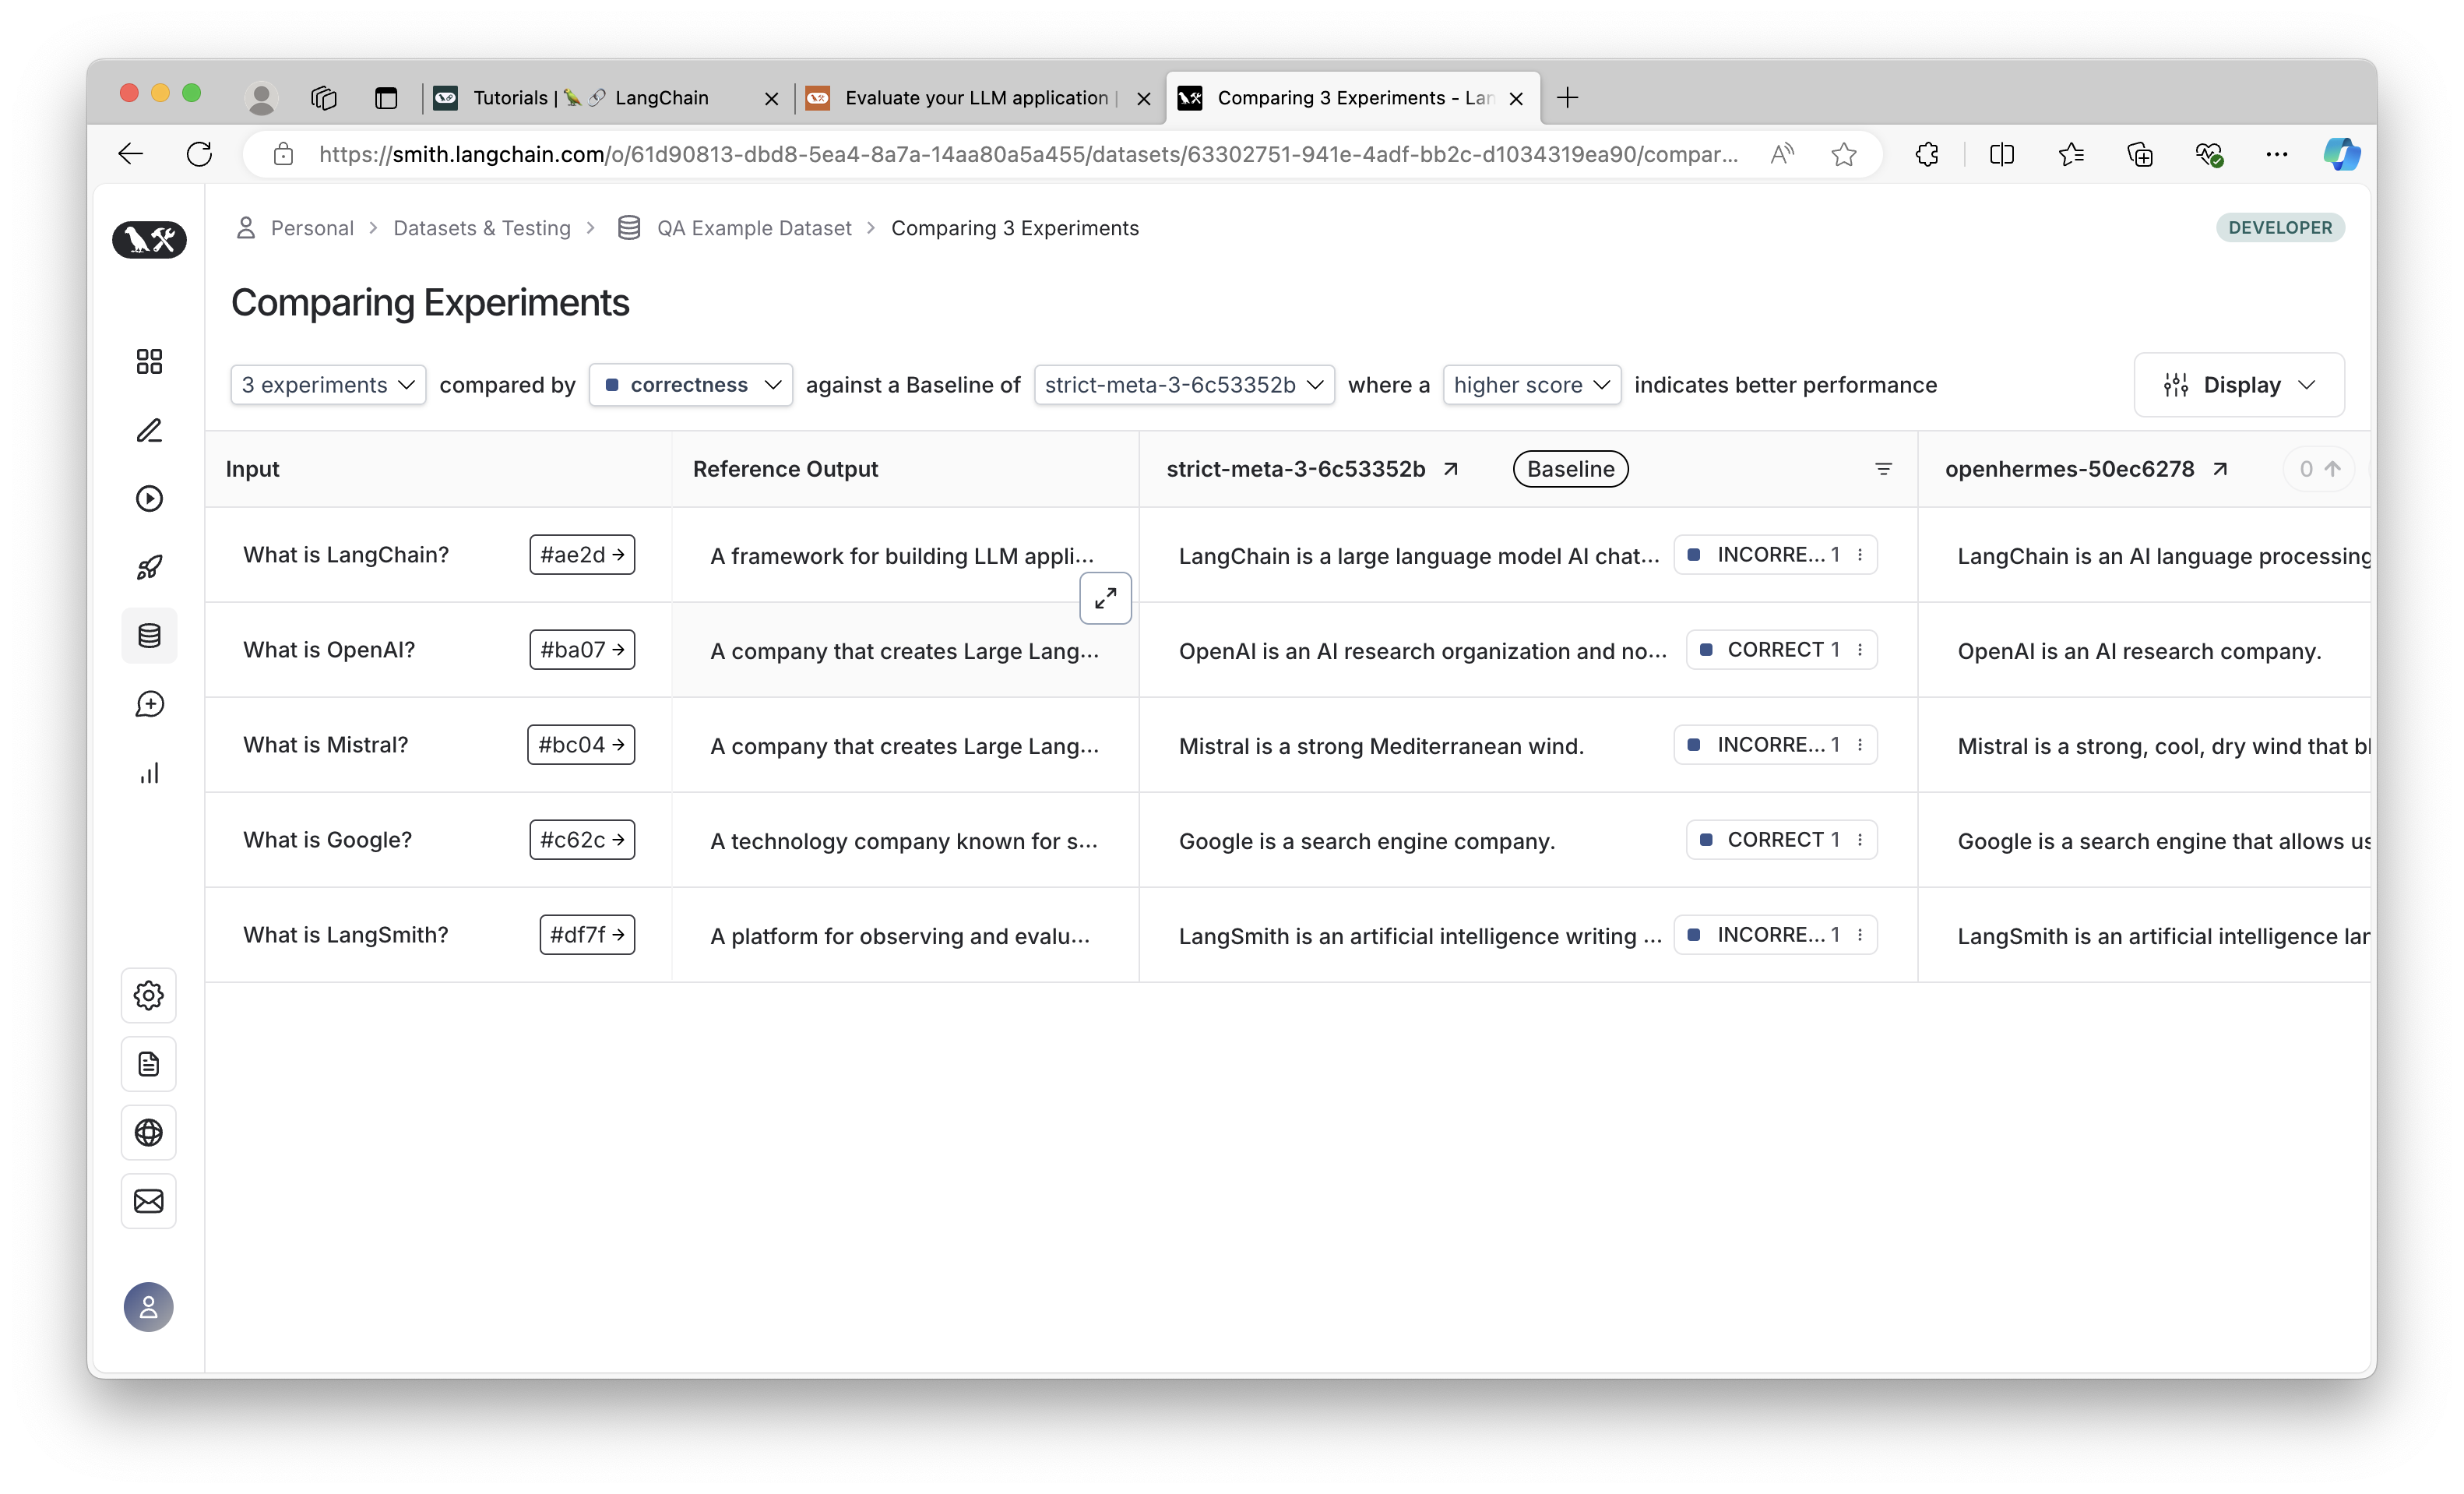

## Set up automated testing to run in CI/CD

In [8]:
def test_length_score() -> None:
    """Test that the length score is at least 80%."""
    experiment_results = evaluate(
        langsmith_app, # Your AI system
        data=dataset_name, # The data to predict and grade over
        evaluators=[evaluate_length, qa_evaluator], # The evaluators to score the results
    )
    # This will be cleaned up in the next release:
    feedback = client.list_feedback(
        run_ids=[r.id for r in client.list_runs(project_name=experiment_results.experiment_name)],
        feedback_key="length"
    )
    scores = [f.score for f in feedback]
    assert sum(scores) / len(scores) >= 0.8, "Aggregate score should be at least .8"